In [1]:
%matplotlib inline

# Introduction

## Purpose

The purpose of this notebook is to analyze the reliability of the manual segmentation performed on datasets from the ALBA Lab Dyslexia Cohort.



## Methods

3 Raters performed manual "cleaning" of the same whole-brain tractography dataset to isolate several white matter bundles of interest in the left hemisphere: Arcuate, SLF-ip, and SLF-tp.

1 of the 3 raters performed manual "cleaning" of the same whole-brain tractography dataset, as above.

Note: there were 4 cases selected, but only the first 3 were cleaned by all raters due to initial uploading error when data was shared. We can go back and do the 4th if needed.

# Import and define paths to data

In [2]:
from glob import glob
import os 
import nibabel as nib
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, plot_roi
from dipy.tracking import utils
import re
import json
from IPython.core.display import Image
import numpy as np

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from dipy.tracking.streamline import transform_streamlines

from dipy.viz import actor, window
from dipy.viz.widget import text

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
RERUN = False

pathpath = '/Users/kesshijordan/paths/dyslexia_controls_basepath.txt'
dyspath_file = open(pathpath, 'r')
dyspath = dyspath_file.read().strip()
dyspath_file.close()

ptdict = json.load(open(
    '/Users/kesshijordan/paths/dyslexia_reliability_ptdict.json'))

In [4]:
mypaths = glob(os.path.join(dyspath, 'DC*/RELIABILITY/*/final/*L.trk'))

In [5]:
def getrefnii(trkpath):
    options = glob('/'.join(trkpath.split('/')[0:7])+'/*fa.nii*')
    if len(options)>1:
        raise('uhoh... pick which reference image')
    else:
        return options[0]

In [6]:
def savenii(array, aff, savepath, savetype='int16'):
    img = nib.Nifti1Image(array.astype(savetype), aff)
    img.to_filename(savepath)

In [7]:
def safesavenii(array, aff, path):
    saveim = nib.Nifti1Image(array.astype("int16"), aff)
    saveim.set_qform(aff, 1)
    saveim.set_sform(aff, 1)
    saveim.to_filename(path)


def save_dmap(trkpath, refnii, savepath=None):
    if savepath is None:
        savepath = trkpath.replace('.trk','_dmap.nii.gz')
    
    trk, hdr = nib.trackvis.read(trkpath)
    new_hdr = hdr.copy()

    sls = [item[0] for item in trk]

    refimg = nib.load(refnii)
    refdata = refimg.get_data()
    refaff = refimg.affine
    orig_vorder = str(hdr['voxel_order'])

    regex_vorder = re.compile('[LlRr][AaPp][SsIi]')
    vorder = re.search(regex_vorder, orig_vorder).group(0)
    new_hdr['voxel_order'] = vorder

    grid2trk_aff = utils.flexi_tvis_affine(vorder, refaff, hdr['dim'],
                                           hdr['voxel_size'])
    dmap = utils.density_map(sls, refdata.shape, affine=grid2trk_aff)

    safesavenii(dmap, refaff, savepath)
    
    return savepath

In [8]:
for trkpath in mypaths:
    refpath = getrefnii(trkpath)
    dmap_path = trkpath.replace('.trk','_dmap.nii.gz')
    if not os.path.exists(dmap_path):
        dmap_path = save_dmap(trkpath, refpath)
        basename = dmap_path.split('/')[-1].split('.')[0]
    #plot_stat_map(dmap_path, bg_img=ref, cmap='cool', threshold=0.1, 
    #              title=dmap_path.split('/')[-3]+'_'+basename)

In [9]:
putdir = '/Users/kesshijordan/repos/notebooks/Dyslexia_Reliability_Analysis_Outputs/'

In [10]:
trklist = ['Arcuate','SLF-ip','SLF-tp']
cutdict = {'Arcuate':[-38,4,21],'SLF-ip':[-38,4,21], 'SLF-tp':[-42,-20,19]}
for ptid in ptdict:
    for trkname in trklist:
        print(ptid)
        print(trkname)
        path_list = glob(os.path.join(dyspath, ptdict[ptid]+
                                         '/RELIABILITY/*/final/'+trkname+'*dmap*'))
        for dmap_path in path_list:
            pngpath = os.path.join(putdir, 'dmap/'+ptid+'_'+trkname+ '_'+
                                   dmap_path.split('/')[-3]+'.png')
            ref = getrefnii(dmap_path)
            if os.path.exists(pngpath):
                Image(pngpath)
            else:
                plot_stat_map(dmap_path, bg_img=ref, cmap='cool', threshold=0.1, 
                          title=ptid+'_'+trkname, output_file=pngpath, cut_coords=cutdict[trkname])

sub01
Arcuate
sub01
SLF-ip
sub01
SLF-tp
sub02
Arcuate
sub02
SLF-ip
sub02
SLF-tp
sub03
Arcuate
sub03
SLF-ip
sub03
SLF-tp


In [11]:
def showren(trkfile, refnii, outpath):
    trk,hdr = nib.trackvis.read(trkfile)
    sls = [item[0] for item in trk]
    
    refimg = nib.load(refnii)
    refdata = refimg.get_data()
    refaff = refimg.affine
    orig_vorder = str(hdr['voxel_order'])

    regex_vorder = re.compile('[LlRr][AaPp][SsIi]')
    vorder = re.search(regex_vorder, orig_vorder).group(0)

    grid2trk_aff = utils.flexi_tvis_affine(vorder, refaff, hdr['dim'],
                                           hdr['voxel_size'])
    
    slsxfm = transform_streamlines(sls, np.linalg.inv(grid2trk_aff))
    
    renderer = window.Renderer()

    stream_actor = actor.line(slsxfm)
    # text_actor = text('text')

    renderer.set_camera(position=(204.49, 20.29, 51.96),
                        focal_point=(70.80, 44.11, 31.85),
                        view_up=(-0.16, -0.09, 0.98))

    renderer.add(stream_actor)
    #renderer.add(text_actor)
    
    # renderer.camera_info()

    # Uncomment the line below to show to display the window
    # window.show(renderer, size=(600, 600), reset_camera=False)
    window.record(renderer, out_path=outpath, size=(600, 600))

    #renderer.camera_info()

In [12]:
uhoh=[]
trklist = ['Arcuate','SLF-ip','SLF-tp']
for ptid in ptdict:
    for trkname in trklist:
        print(ptid)
        print(trkname)
        path_list = glob(os.path.join(dyspath, ptdict[ptid]+
                                         '/RELIABILITY/*/final/'+trkname+'*.trk'))
        for trk_path in path_list:
            try:
                refnii = getrefnii(trk_path)
                pngpath = os.path.join(putdir, 'sshots/'+ptid+'_'+trkname+ '_'+
                                       trk_path.split('/')[-3]+'.png')
                print(pngpath)
                showren(trk_path, refnii, pngpath)
            except:
                uhoh.append(trk_path)
print(uhoh)

sub01
Arcuate
/Users/kesshijordan/repos/notebooks/Dyslexia_Reliability_Analysis_Outputs/sshots/sub01_Arcuate_Edu1.png
/Users/kesshijordan/repos/notebooks/Dyslexia_Reliability_Analysis_Outputs/sshots/sub01_Arcuate_Edu2.png
/Users/kesshijordan/repos/notebooks/Dyslexia_Reliability_Analysis_Outputs/sshots/sub01_Arcuate_Kesshi.png
/Users/kesshijordan/repos/notebooks/Dyslexia_Reliability_Analysis_Outputs/sshots/sub01_Arcuate_Malu.png
sub01
SLF-ip
/Users/kesshijordan/repos/notebooks/Dyslexia_Reliability_Analysis_Outputs/sshots/sub01_SLF-ip_Edu1.png
/Users/kesshijordan/repos/notebooks/Dyslexia_Reliability_Analysis_Outputs/sshots/sub01_SLF-ip_Edu2.png
/Users/kesshijordan/repos/notebooks/Dyslexia_Reliability_Analysis_Outputs/sshots/sub01_SLF-ip_Kesshi.png
/Users/kesshijordan/repos/notebooks/Dyslexia_Reliability_Analysis_Outputs/sshots/sub01_SLF-ip_Malu.png
sub01
SLF-tp
/Users/kesshijordan/repos/notebooks/Dyslexia_Reliability_Analysis_Outputs/sshots/sub01_SLF-tp_Edu1.png
/Users/kesshijordan/repos

# To do

- Make intra- and inter-rater comparison PCVA to CSV
- Compare metrics (FA, MD) between raters
- Make merged versions with agreement/disagreement
- Make streamline renders
- see how much difference in the proportion of the tracks of the Arcuate/SLF complex
- Volume, FA, MD
- Show AFQ
- Waiver for de-identified data general sharing. Keep it when submitting grants... submit it to the receiving institution to keep a copy
- what does Trang want to do?
- Freesurfer WM mask and MD
- Right vs. Left

- signs of ALS (clinical reports from PPG)

In [13]:
def return_pcva(dm1_path, dm2_path, thr=0):

    dm1_img = nib.load(dm1_path)
    dm2_img = nib.load(dm2_path)

    dm1_data = dm1_img.get_data()
    dm2_data = dm2_img.get_data()

    bool1_data = (dm1_data > thr)
    bool2_data = (dm2_data > thr)

    yes_yes = bool1_data & bool2_data

    volvx1 = sum(sum(sum(bool1_data)))
    volvx2 = sum(sum(sum(bool2_data)))

    yyvolvx = sum(sum(sum(yes_yes)))

    PCVA = np.multiply(np.true_divide(yyvolvx, 
                                      np.add(volvx1, volvx2)), 200)

    return PCVA, volvx1, volvx2

In [14]:
def return_metric(dmap, metric_image, thr=0):
    dmap = nib.load(dmap).get_data()
    metric = nib.load(metric_image).get_data()
    mean_metric = np.average(metric[dmap>thr])
    return mean_metric

# PCVA Analysis

In [15]:
for thr in [0,1,5,10]:
    pcva_block = np.ones([4,4,9])
    k=0
    title_list = []
    for ptid in ptdict:
        for trkname in trklist:
            print(ptid)
            print(trkname)
            path_list = glob(os.path.join(dyspath, ptdict[ptid]+
                                             '/RELIABILITY/*/final/'+trkname+'*dmap*'))
            for i,path1 in enumerate(path_list):
                for j,path2 in enumerate(path_list):
                    print(path1.split('/')[-3]+' vs '+path2.split('/')[-3])
                    pcva, vol1, vol2 = return_pcva(path1,path2, thr=thr)
                    print(pcva, vol1, vol2)
                    pcva_block[i,j,k] = pcva
            title_list.append(ptid+'_'+trkname)
            k+=1

    for i in range(9):
        print(i)
        df = pd.DataFrame(pcva_block[:,:,i], columns=['Edu1','Edu2','Kesshi','Malu'], 
                          index=['Edu1','Edu2','Kesshi','Malu'])
        #plt.subplots([3,3,i])
        myplot = sns.heatmap(df, annot=True, linewidths=.5, cbar=True, cmap='plasma',vmin=70, vmax=100)
        myplot.set_title(title_list[i]+'_thr_'+str(thr))
        fig = myplot.get_figure()
        fig.savefig(putdir+'pcva_thr'+str(thr)+'/pcva_'+title_list[i]+'.png')
        plt.clf()

sub01
Arcuate
Edu1 vs Edu1
100.0 6289 6289
Edu1 vs Edu2
91.71974522292994 6289 6114
Edu1 vs Kesshi
92.96715834080352 6289 5982
Edu1 vs Malu
86.89093116004855 6289 5245
Edu2 vs Edu1
91.71974522292994 6114 6289
Edu2 vs Edu2
100.0 6114 6114
Edu2 vs Kesshi
91.58399470899471 6114 5982
Edu2 vs Malu
87.49009595915133 6114 5245
Kesshi vs Edu1
92.96715834080352 5982 6289
Kesshi vs Edu2
91.58399470899471 5982 6114
Kesshi vs Kesshi
100.0 5982 5982
Kesshi vs Malu
86.98672842255277 5982 5245
Malu vs Edu1
86.89093116004855 5245 6289
Malu vs Edu2
87.49009595915133 5245 6114
Malu vs Kesshi
86.98672842255277 5245 5982
Malu vs Malu
100.0 5245 5245
sub01
SLF-ip
Edu1 vs Edu1
100.0 4550 4550
Edu1 vs Edu2
66.96024464831805 4550 3625
Edu1 vs Kesshi
71.09162024416261 4550 3887
Edu1 vs Malu
60.7611211108254 4550 3228
Edu2 vs Edu1
66.96024464831805 3625 4550
Edu2 vs Edu2
100.0 3625 3625
Edu2 vs Kesshi
89.35037273695421 3625 3887
Edu2 vs Malu
84.34262366846636 3625 3228
Kesshi vs Edu1
71.09162024416261 3887 4550

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


0.0 677 0
Malu vs Malu
100.0 677 677
sub02
SLF-tp
Edu1 vs Edu1
100.0 3262 3262
Edu1 vs Edu2
82.98163880515209 3262 4036
Edu1 vs Kesshi
78.65203277168033 3262 3207
Edu1 vs Malu
74.62098241358399 3262 3334
Edu2 vs Edu1
82.98163880515209 4036 3262
Edu2 vs Edu2
100.0 4036 4036
Edu2 vs Kesshi
80.21538036725114 4036 3207
Edu2 vs Malu
80.67842605156038 4036 3334
Kesshi vs Edu1
78.65203277168033 3207 3262
Kesshi vs Edu2
80.21538036725114 3207 4036
Kesshi vs Kesshi
100.0 3207 3207
Kesshi vs Malu
84.39076593792998 3207 3334
Malu vs Edu1
74.62098241358399 3334 3262
Malu vs Edu2
80.67842605156038 3334 4036
Malu vs Kesshi
84.39076593792998 3334 3207
Malu vs Malu
100.0 3334 3334
sub03
Arcuate
Edu1 vs Edu1
100.0 5562 5562
Edu1 vs Edu2
88.91663465232425 5562 4850
Edu1 vs Kesshi
84.24110384894699 5562 4077
Edu1 vs Malu
73.23013885727293 5562 3224
Edu2 vs Edu1
88.91663465232425 4850 5562
Edu2 vs Edu2
100.0 4850 4850
Edu2 vs Kesshi
90.98241290467122 4850 4077
Edu2 vs Malu
79.8612831310379 4850 3224
Kessh

92.8675825781935 3551 3291
Edu2 vs Malu
90.41470454200213 3551 3032
Kesshi vs Edu1
93.56098972652293 3291 3620
Kesshi vs Edu2
92.8675825781935 3291 3551
Kesshi vs Kesshi
100.0 3291 3291
Kesshi vs Malu
90.05219041594181 3291 3032
Malu vs Edu1
90.43896572459411 3032 3620
Malu vs Edu2
90.41470454200213 3032 3551
Malu vs Kesshi
90.05219041594181 3032 3291
Malu vs Malu
100.0 3032 3032
sub01
SLF-ip
Edu1 vs Edu1
100.0 2535 2535
Edu1 vs Edu2
61.760530052058684 2535 1691
Edu1 vs Kesshi
65.84305650880805 2535 1836
Edu1 vs Malu
54.380207018429694 2535 1426
Edu2 vs Edu1
61.760530052058684 1691 2535
Edu2 vs Edu2
100.0 1691 1691
Edu2 vs Kesshi
90.5585483413666 1691 1836
Edu2 vs Malu
83.47770291947386 1691 1426
Kesshi vs Edu1
65.84305650880805 1836 2535
Kesshi vs Edu2
90.5585483413666 1836 1691
Kesshi vs Kesshi
100.0 1836 1836
Kesshi vs Malu
83.38442673206622 1836 1426
Malu vs Edu1
54.380207018429694 1426 2535
Malu vs Edu2
83.47770291947386 1426 1691
Malu vs Kesshi
83.38442673206622 1426 1836
Malu vs

0.0 0 122
Malu vs Edu1
12.5 122 438
Malu vs Edu2
39.89501312335958 122 259
Malu vs Kesshi
0.0 122 0
Malu vs Malu
100.0 122 122
sub02
SLF-tp
Edu1 vs Edu1
100.0 1297 1297
Edu1 vs Edu2
79.07881933181966 1297 1786
Edu1 vs Kesshi
80.97133757961782 1297 1215
Edu1 vs Malu
70.96027767065175 1297 1296
Edu2 vs Edu1
79.07881933181966 1786 1297
Edu2 vs Edu2
100.0 1786 1786
Edu2 vs Kesshi
78.24058647117627 1786 1215
Edu2 vs Malu
77.93640493186243 1786 1296
Kesshi vs Edu1
80.97133757961782 1215 1297
Kesshi vs Edu2
78.24058647117627 1215 1786
Kesshi vs Kesshi
100.0 1215 1215
Kesshi vs Malu
79.96814018319395 1215 1296
Malu vs Edu1
70.96027767065175 1296 1297
Malu vs Edu2
77.93640493186243 1296 1786
Malu vs Kesshi
79.96814018319395 1296 1215
Malu vs Malu
100.0 1296 1296
sub03
Arcuate
Edu1 vs Edu1
100.0 2218 2218
Edu1 vs Edu2
85.39959016393442 2218 1686
Edu1 vs Kesshi
78.43244724582077 2218 1431
Edu1 vs Malu
68.67969212551806 2218 1160
Edu2 vs Edu1
85.39959016393442 1686 2218
Edu2 vs Edu2
100.0 1686 168

In [16]:
print(title_list)

['sub01_Arcuate', 'sub01_SLF-ip', 'sub01_SLF-tp', 'sub02_Arcuate', 'sub02_SLF-ip', 'sub02_SLF-tp', 'sub03_Arcuate', 'sub03_SLF-ip', 'sub03_SLF-tp']


sub01_SLF-ip


/Users/kesshijordan/anaconda/lib/python3.6/site-packages/nilearn/image/resampling.py:481: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


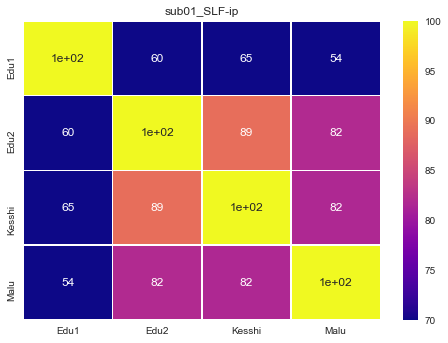

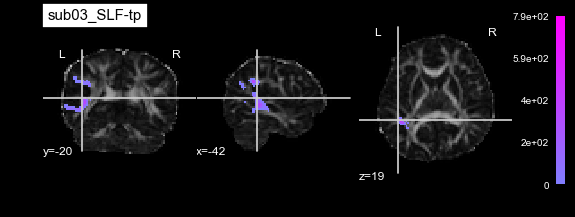

In [17]:
idx = 1
print(title_list[idx])
df = pd.DataFrame(pcva_block[:,:,idx], columns=['Edu1','Edu2','Kesshi','Malu'], 
                  index=['Edu1','Edu2','Kesshi','Malu'])
sns.heatmap(df, annot=True, linewidths=.5, cmap='plasma', vmin=70)
plt.title(title_list[idx])
plot_stat_map(dmap_path, bg_img=ref, cmap='cool', threshold=thr, 
                          title=ptid+'_'+trkname, cut_coords=cutdict[trkname])

In [18]:
path_list

['/Users/kesshijordan/ref_data/dyslexia_children/TRIO_reliability/DC20894/RELIABILITY/Edu1/final/SLF-tp_L_dmap.nii.gz',
 '/Users/kesshijordan/ref_data/dyslexia_children/TRIO_reliability/DC20894/RELIABILITY/Edu2/final/SLF-tp_L_dmap.nii.gz',
 '/Users/kesshijordan/ref_data/dyslexia_children/TRIO_reliability/DC20894/RELIABILITY/Kesshi/final/SLF-tp_L_dmap.nii.gz',
 '/Users/kesshijordan/ref_data/dyslexia_children/TRIO_reliability/DC20894/RELIABILITY/Malu/final/SLF-tp_L_dmap.nii.gz']

In [19]:
def return_overlap(imlist, putpath, thr=0):
    baseim = nib.load(imlist[0])
    aff = baseim.affine
    baseim = baseim.get_data()*0
    #print(sum(sum(sum(baseim))))
    for im in imlist:
        nextim = nib.load(im).get_data()*1
        nextim = 1*(nextim > thr)
        baseim += nextim
        #print(sum(sum(sum(baseim))))
    safesavenii(baseim, aff, putpath)
    return putpath

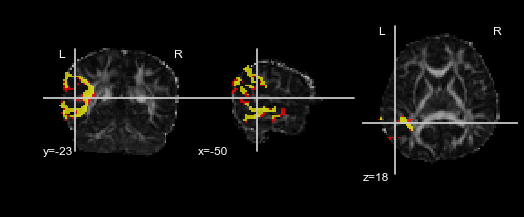

In [20]:
newpath = return_overlap(path_list[0:2], 'test.nii.gz', thr=1)
plot_roi(newpath, cmap='autumn', bg_img=getrefnii(path_list[0]))

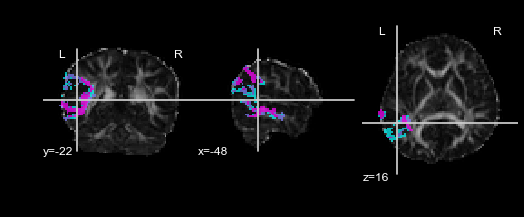

In [21]:
newpath = return_overlap(path_list[1:4], 'test2.nii.gz', thr=1)
plot_roi(newpath, cmap='cool', bg_img=getrefnii(path_list[0]))

In [22]:
for thr in [1]:
    title_list = []
    for ptid in ptdict:
        for trkname in trklist:
            print(ptid)
            print(trkname)
            path_list = glob(os.path.join(dyspath, ptdict[ptid]+
                                             '/RELIABILITY/*/final/'+trkname+'*dmap*'))
            print([i.split('/')[-3] for i in path_list])
            intrapath = os.path.join('Dyslexia_Reliability_Analysis_Outputs/intra_thr1/'+'intra_'+ptid+'_'+trkname)
            
            interpath = os.path.join('Dyslexia_Reliability_Analysis_Outputs/inter_thr1/'+'inter_'+ptid+'_'+trkname)
            
            inter_impath = return_overlap(path_list[1:4], interpath+'.nii.gz', thr=1)
            plot_roi(inter_impath, cmap='cool', bg_img=getrefnii(path_list[0]), output_file=interpath+'.png')
            intra_impath = return_overlap(path_list[0:2], intrapath+'.nii.gz', thr=1)
            plot_roi(intra_impath, cmap='autumn', bg_img=getrefnii(path_list[0]), output_file=intrapath+'.png')
            
            '''for i,path1 in enumerate(path_list):
                for j,path2 in enumerate(path_list):
                    print(path1.split('/')[-3]+' vs '+path2.split('/')[-3])
                    pcva, vol1, vol2 = return_pcva(path1,path2, thr=thr)
                    print(pcva, vol1, vol2)
                    pcva_block[i,j,k] = pcva
            title_list.append(ptid+'_'+trkname)'''


sub01
Arcuate
['Edu1', 'Edu2', 'Kesshi', 'Malu']
sub01
SLF-ip
['Edu1', 'Edu2', 'Kesshi', 'Malu']
sub01
SLF-tp
['Edu1', 'Edu2', 'Kesshi', 'Malu']
sub02
Arcuate
['Edu1', 'Edu2', 'Kesshi', 'Malu']
sub02
SLF-ip
['Edu1', 'Edu2', 'Kesshi', 'Malu']
sub02
SLF-tp
['Edu1', 'Edu2', 'Kesshi', 'Malu']
sub03
Arcuate
['Edu1', 'Edu2', 'Kesshi', 'Malu']
sub03
SLF-ip
['Edu1', 'Edu2', 'Kesshi', 'Malu']
sub03
SLF-tp
['Edu1', 'Edu2', 'Kesshi', 'Malu']


# Calculate Metrics

## Functions

In [229]:
def loadnii(niipath):
    img = nib.load(niipath)
    data = img.get_data()
    aff = img.affine
    return data, aff

def calc_vol_from_dmap(dmap_path, thr=0):
    data, aff = loadnii(dmap_path)
    data = 1*(data > thr)
    volume = sum(sum(sum(data)))
    return volume

def calc_vol_from_dmap_twomask(dmap_path, mask_path, thr=0):
    data, aff = loadnii(dmap_path)
    mask, maskaff = loadnii(mask_path)
    data = 1*(data > thr)
    mask = 1*(mask > 0)
    masked_data = np.multiply(data, mask)
    volume = sum(sum(sum(masked_data)))
    return volume

def calc_metric_from_dmap(dmap_path, metric_path, thr=0):
    dmdata, dmaff = loadnii(dmap_path)
    dmdata = 1*(dmdata > thr)
    mdata, maff = loadnii(metric_path)
    if np.any(dmaff != maff):
        raise('uhoh... mismatched mask volume')
    mean = np.mean(mdata[dmdata > 0])
    return mean

def calc_metric_from_dmap_twomask(dmap_path, metric_path, mask_path, thr=0):
    mask, maskaff = loadnii(mask_path)
    mask = 1*(mask > 0)
    
    dmdata, dmaff = loadnii(dmap_path)
    dmdata = 1*(dmdata > thr)
    
    masked_data = np.multiply(dmdata, mask)
    
    mdata, maff = loadnii(metric_path)
    
    mean = np.mean(mdata[masked_data > 0])
    return mean

In [135]:
def newdf():
    raters = ['Edu1', 'Edu2', 'Kesshi', 'Malu']
    nvols = len(ptdict)*len(trklist)
    voldf = pd.DataFrame(np.zeros([nvols,4+2]),columns = raters+['file_name', 'ptid'])
    voldf['file_name'] = 'null'
    return voldf

In [211]:
voldf = newdf()
fadf = newdf()
mddf = newdf()

hop = 0
for thr in [1]:
    title_list = []
    for ptid in ptdict:
        
        fa_path = glob(os.path.join(dyspath, ptdict[ptid]+'/*fa.nii*'))
        md_path = glob(os.path.join(dyspath, ptdict[ptid]+'/*md.nii*'))
        assert(len(fa_path)==1)
        assert(len(md_path)==1)
        fa_path = fa_path[0]
        md_path = md_path[0]
        #print(fa_path)
        #print(md_path)
        
        for trkname in trklist:
            #print(ptid)
            #print(trkname)
            path_list = glob(os.path.join(dyspath, ptdict[ptid]+
                                          '/RELIABILITY/*/final/'+
                                          trkname+'*dmap*'))
            #print([i.split('/')[-3] for i in path_list])
            
            vol_list = []
            fa_list = []
            md_list = []
            for path in path_list:
                vol_list.append(calc_vol_from_dmap(path, thr=thr))
                fa_list.append(calc_metric_from_dmap(path, fa_path, thr=thr))
                md_list.append(calc_metric_from_dmap(path, md_path, thr=thr))
            voldf.iloc[hop] = vol_list+[path,ptid]
            fadf.iloc[hop] = fa_list+[path,ptid]
            mddf.iloc[hop] = md_list+[path,ptid]
            hop+=1

    voldf['trackid'] = voldf['file_name'].str.split('/').str.get(-1).str.split('_').str.get(0)            
    voldf.to_csv(os.path.join(putdir, 'Volume_Reliability_thr'+str(thr)+'.csv'))
    #voldf.set_index(['ptid','trackid'])
    voldf.drop(['file_name'],axis=1, inplace=True)
    volmelt = pd.melt(voldf, ['ptid','trackid'], value_name='Volume')
    
    fadf['trackid'] = fadf['file_name'].str.split('/').str.get(-1).str.split('_').str.get(0)            
    fadf.to_csv(os.path.join(putdir, 'FA_Reliability_thr'+str(thr)+'.csv'))
    #fadf.set_index(['ptid','trackid'], inplace)
    fadf.drop(['file_name'],axis=1, inplace=True)
    famelt = pd.melt(fadf, ['ptid','trackid'], value_name='avg_FA')
    
    mddf['trackid'] = mddf['file_name'].str.split('/').str.get(-1).str.split('_').str.get(0)            
    mddf.to_csv(os.path.join(putdir, 'MD_Reliability_thr'+str(thr)+'.csv'))
    #mddf.set_index(['ptid','trackid'])
    mddf.drop(['file_name'],axis=1, inplace=True)
    mdmelt = pd.melt(mddf, ['ptid','trackid'], value_name='avg_MD')

/Users/kesshijordan/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kesshijordan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


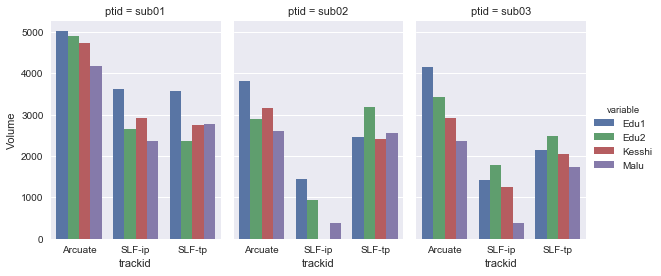

In [212]:
g = sns.factorplot(x="trackid", y="Volume",
...                    hue="variable", col="ptid",
...                    data=volmelt, kind="bar",
...                    size=4, aspect=.7);

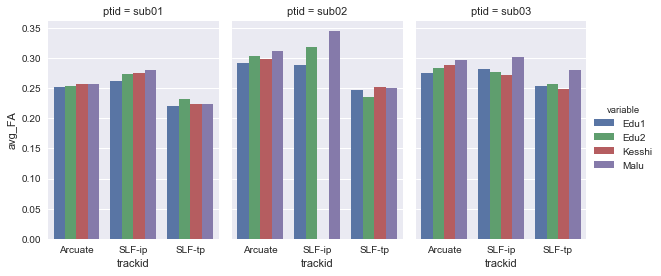

In [213]:
g = sns.factorplot(x="trackid", y="avg_FA",
...                    hue="variable", col="ptid",
...                    data=famelt, kind="bar",
...                    size=4, aspect=.7);

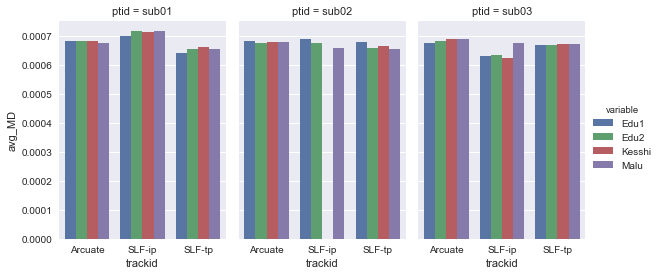

In [206]:
g = sns.factorplot(x="trackid", y="avg_MD",
...                    hue="variable", col="ptid",
...                    data=mdmelt, kind="bar",
...                    size=4, aspect=.7);

In [230]:
voldf = newdf()
fadf = newdf()
mddf = newdf()

hop = 0
for thr in [1]:
    title_list = []
    for ptid in ptdict:
        
        fa_path = glob(os.path.join(dyspath, ptdict[ptid]+'/*fa.nii*'))
        md_path = glob(os.path.join(dyspath, ptdict[ptid]+'/*md.nii*'))
        wm_path = glob(os.path.join(dyspath, ptdict[ptid]+'/WM_L_diffsp.nii.gz'))
        assert(len(fa_path)==1)
        assert(len(md_path)==1)
        assert(len(wm_path)==1)
        fa_path = fa_path[0]
        md_path = md_path[0]
        wm_path = wm_path[0]
        #print(fa_path)
        #print(md_path)
        
        for trkname in trklist:
            #print(ptid)
            #print(trkname)
            path_list = glob(os.path.join(dyspath, ptdict[ptid]+
                                          '/RELIABILITY/*/final/'+
                                          trkname+'*dmap*'))
            #print([i.split('/')[-3] for i in path_list])
            
            vol_list = []
            fa_list = []
            md_list = []
            for path in path_list:
                vol_list.append(calc_vol_from_dmap_twomask(path, wm_path, thr=thr))
                fa_list.append(calc_metric_from_dmap_twomask(path, fa_path, wm_path, thr=thr))
                md_list.append(calc_metric_from_dmap_twomask(path, md_path, wm_path, thr=thr))
            voldf.iloc[hop] = vol_list+[path,ptid]
            fadf.iloc[hop] = fa_list+[path,ptid]
            mddf.iloc[hop] = md_list+[path,ptid]
            hop+=1

    voldf['trackid'] = voldf['file_name'].str.split('/').str.get(-1).str.split('_').str.get(0)            
    voldf.to_csv(os.path.join(putdir, 'Volume_Reliability_thr'+str(thr)+'.csv'))
    #voldf.set_index(['ptid','trackid'])
    voldf.drop(['file_name'],axis=1, inplace=True)
    volmelt = pd.melt(voldf, ['ptid','trackid'], value_name='Volume')
    
    fadf['trackid'] = fadf['file_name'].str.split('/').str.get(-1).str.split('_').str.get(0)            
    fadf.to_csv(os.path.join(putdir, 'FA_Reliability_thr'+str(thr)+'.csv'))
    #fadf.set_index(['ptid','trackid'], inplace)
    fadf.drop(['file_name'],axis=1, inplace=True)
    famelt = pd.melt(fadf, ['ptid','trackid'], value_name='avg_FA')
    
    mddf['trackid'] = mddf['file_name'].str.split('/').str.get(-1).str.split('_').str.get(0)            
    mddf.to_csv(os.path.join(putdir, 'MD_Reliability_thr'+str(thr)+'.csv'))
    #mddf.set_index(['ptid','trackid'])
    mddf.drop(['file_name'],axis=1, inplace=True)
    mdmelt = pd.melt(mddf, ['ptid','trackid'], value_name='avg_MD')

/Users/kesshijordan/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kesshijordan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


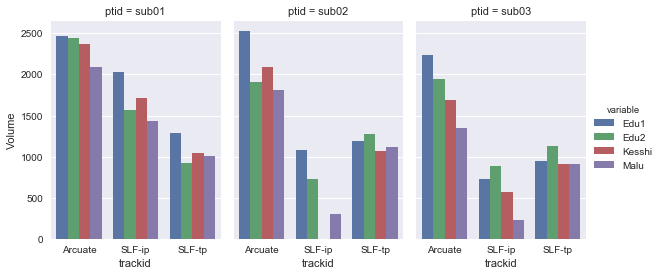

In [231]:
g = sns.factorplot(x="trackid", y="Volume",
...                    hue="variable", col="ptid",
...                    data=volmelt, kind="bar",
...                    size=4, aspect=.7);

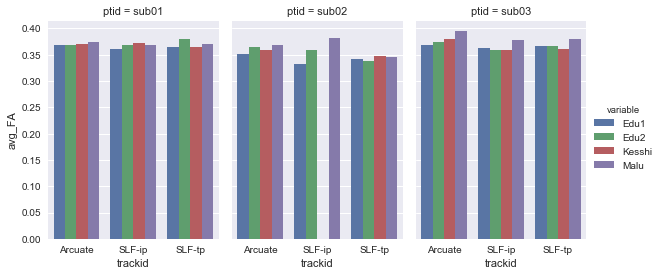

In [232]:
g = sns.factorplot(x="trackid", y="avg_FA",
...                    hue="variable", col="ptid",
...                    data=famelt, kind="bar",
...                    size=4, aspect=.7);

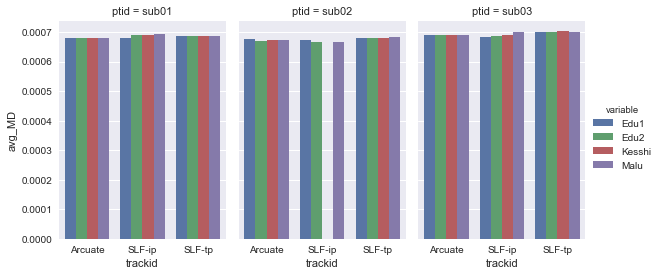

In [233]:
g = sns.factorplot(x="trackid", y="avg_MD",
...                    hue="variable", col="ptid",
...                    data=mdmelt, kind="bar",
...                    size=4, aspect=.7);

In [327]:
def merge_dmaps(pathlist, maskpath=None, thr=0, savepath=None):
    agg, aff = loadnii(pathlist[0])
    agg = 1*(agg > thr)
    print(pathlist[0].split('/')[-1])
    print(sum(sum(sum(agg))))
    for path in pathlist[1:]:
        print(path.split('/')[-1])
        temp, tempaff = loadnii(path)
        temp = 1*(temp > thr)
        assert(np.all(tempaff == aff))
        agg+=temp
        agg = 1*(agg>0)
        print(sum(sum(sum(agg))))
    if maskpath is not None:
        mask, maskaff = loadnii(maskpath)
        mask = 1*(mask > 0)
        print("masking")
        agg = np.multiply(mask, agg)
        agg = 1*(agg>0)
        print(sum(sum(sum(agg))))
    if savepath is not None:
        savenii(agg, aff, savepath)
    return sum(sum(sum(agg)))

In [462]:
pct_vol_df = pd.DataFrame(np.zeros([12,3]), columns=['rater','ptid','volume'])
hop=0
for ptid in ptdict:
    print(ptid)
    wm_path = glob(os.path.join(dyspath, ptdict[ptid]+'/WM_L_diffsp.nii.gz'))
    wm_path = wm_path[0]
    for rater in raters:
        pathlist = glob(os.path.join(dyspath, ptdict[ptid]+'/RELIABILITY/'+rater+'/final/*dmap*.nii*'))
        #print(rater)
        #print(len(pathlist))
        savepath = os.path.join(dyspath, ptdict[ptid]+'/RELIABILITY/'+rater+'/final/Merged_thr1.nii.gz')
        vol = merge_dmaps(pathlist, wm_path, thr=1, savepath=savepath)
        pct_vol_df.iloc[hop] = [rater, ptid, vol]
        hop+=1

sub01
Arcuate_L_dmap.nii.gz
5017
SLF-ip_L_dmap.nii.gz
6533
SLF-tp_L_dmap.nii.gz
8426
masking
3742
Arcuate_L_dmap.nii.gz
4907
SLF-ip_L_dmap.nii.gz
6535
SLF-tp_L_dmap.nii.gz
7538
masking
3554
Arcuate_L_dmap.nii.gz
4720
SLF-ip_L_dmap.nii.gz
6572
SLF-tp_L_dmap.nii.gz
7895
masking
3654
Arcuate_L_dmap.nii.gz
4187
SLF-ip_L_dmap.nii.gz
5721
SLF-tp_L_dmap.nii.gz
7233
masking
3340
sub02
Arcuate_L_dmap.nii.gz
3809
SLF-ip_L_dmap.nii.gz
4626
SLF-tp_L_dmap.nii.gz
6094
masking
3579
Arcuate_L_dmap.nii.gz
2885
SLF-ip_L_dmap.nii.gz
3141
SLF-tp_L_dmap.nii.gz
5336
masking
2663
Arcuate_L_dmap.nii.gz
3152
SLF-ip_L_dmap.nii.gz
3152
SLF-tp_L_dmap.nii.gz
4775
masking
2615
Arcuate_L_dmap.nii.gz
2604
SLF-ip_L_dmap.nii.gz
2767
SLF-tp_L_dmap.nii.gz
4547
masking
2470
sub03
Arcuate_L_dmap.nii.gz
4155
SLF-ip_L_dmap.nii.gz
5060
SLF-tp_L_dmap.nii.gz
5869
masking
2844
Arcuate_L_dmap.nii.gz
3434
SLF-ip_L_dmap.nii.gz
4659
SLF-tp_L_dmap.nii.gz
5800
masking
2812
Arcuate_L_dmap.nii.gz
2928
SLF-ip_L_dmap.nii.gz
3942
SLF-tp_L_

In [468]:
pct_vol_df_idx = pct_vol_df.set_index(['rater','ptid'])

In [471]:
pct_vol_df_idx

,,volume
rater,ptid,
Edu1,sub01,3742.0
Edu2,sub01,3554.0
Kesshi,sub01,3654.0
Malu,sub01,3340.0
Edu1,sub02,3579.0
Edu2,sub02,2663.0
Kesshi,sub02,2615.0
Malu,sub02,2470.0
Edu1,sub03,2844.0


In [472]:
volmelt

,ptid,trackid,variable,Volume
0,sub01,Arcuate,Edu1,2464.0
1,sub01,SLF-ip,Edu1,2028.0
2,sub01,SLF-tp,Edu1,1290.0
3,sub02,Arcuate,Edu1,2527.0
4,sub02,SLF-ip,Edu1,1078.0
5,sub02,SLF-tp,Edu1,1187.0
6,sub03,Arcuate,Edu1,2238.0
7,sub03,SLF-ip,Edu1,728.0
8,sub03,SLF-tp,Edu1,944.0
9,sub01,Arcuate,Edu2,2439.0


In [473]:
pct_vol_df

,rater,ptid,volume
0,Edu1,sub01,3742.0
1,Edu2,sub01,3554.0
2,Kesshi,sub01,3654.0
3,Malu,sub01,3340.0
4,Edu1,sub02,3579.0
5,Edu2,sub02,2663.0
6,Kesshi,sub02,2615.0
7,Malu,sub02,2470.0
8,Edu1,sub03,2844.0
9,Edu2,sub03,2812.0


In [474]:
pctvolmelt = volmelt.copy()
pctvolmelt['agg_Volume'] = 'null'
pctvolmelt['pct_Volume'] = 'null'
for i in pctvolmelt.index:
    #print(pctvolmelt.get_value(i,'ptid'))
    #print(pctvolmelt.get_value(i,'variable'))
    bigvol = pct_vol_df_idx.loc[pctvolmelt.get_value(i,'variable'),pctvolmelt.get_value(i,'ptid')].values[0]
    pctvolmelt.set_value(i,'agg_Volume',value=bigvol)
    pctvol = pctvolmelt.get_value(i,'Volume')/bigvol
    pctvolmelt.set_value(i,'pct_Volume',value=pctvol)

In [475]:
pctvolmelt

,ptid,trackid,variable,Volume,agg_Volume,pct_Volume
0,sub01,Arcuate,Edu1,2464.0,3742,0.658471
1,sub01,SLF-ip,Edu1,2028.0,3742,0.541956
2,sub01,SLF-tp,Edu1,1290.0,3742,0.344735
3,sub02,Arcuate,Edu1,2527.0,3579,0.706063
4,sub02,SLF-ip,Edu1,1078.0,3579,0.301201
5,sub02,SLF-tp,Edu1,1187.0,3579,0.331657
6,sub03,Arcuate,Edu1,2238.0,2844,0.78692
7,sub03,SLF-ip,Edu1,728.0,2844,0.255977
8,sub03,SLF-tp,Edu1,944.0,2844,0.331927
9,sub01,Arcuate,Edu2,2439.0,3554,0.686269


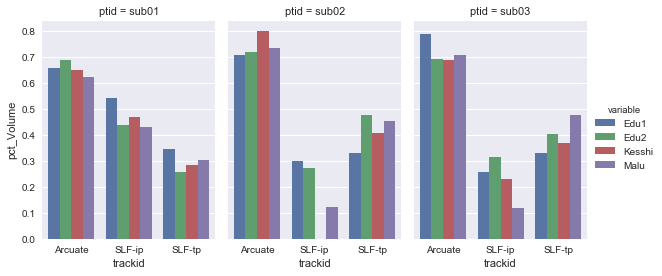

In [476]:
g = sns.factorplot(x="trackid", y="pct_Volume",
...                    hue="variable", col="ptid",
...                    data=pctvolmelt, kind="bar",
...                    size=4, aspect=.7);

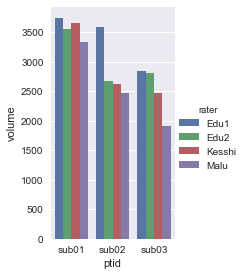

In [481]:
g = sns.factorplot(x="ptid", y="volume",
...                    hue="rater",
...                    data=pct_vol_df, kind="bar",
...                    size=4, aspect=.7);